# Imports

In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os
import math
import itertools
from IPython.display import display_html

# Import Pandas
import pandas as pd

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.vis as grvis

from gesturerec.data import SensorData
from gesturerec.data import GestureSet

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

---
# Utils

In [2]:
def display_tables_side_by_side(df1, df2, n = None, df1_caption = "Caption table 1", df2_caption = "Caption table 2"):
    '''Displays the two tables side-by-side'''
    
    if n is not None:
        df1 = df1.head(n)
        df2 = df2.head(n)
    
    # Solution from https://stackoverflow.com/a/50899244
    df1_styler = df1.style.set_table_attributes("style='display:inline; margin:10px'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
    
def print_folds(cross_validator, X, y_true, trial_indices):
    '''Prints out the k-fold splits'''
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        print("TEST FOLD {}".format(fold_cnt))
        for i in test_index:
            print("\t{} {}".format(y_true[i], trial_indices[i]))
        fold_cnt += 1
        
def display_folds(cross_validator, X, y_true, trial_indices):
    map_fold_to_class_labels = dict()
    fold_cnt = 0
    for train_index, test_index in cross_validator.split(X, y_true):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_true.iloc[train_index], y_true.iloc[test_index]
        
        class_labels = []
        for i in test_index:
            class_labels.append(f"{y_true[i]} {trial_indices[i]}")
        
        map_fold_to_class_labels[f"Fold {fold_cnt}"] = class_labels
        fold_cnt += 1
    
    df = pd.DataFrame(map_fold_to_class_labels)
    display(df)


def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peaks
    # JonTODO: in future, could add in support for min horizontal distance so we don't find peaks close together
    # SciPy's find_peaks supports this, so would be straightforward to implement
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}


def plot_feature_1d(gesture_set, extract_feature_func, title = None, use_random_y_jitter = True,
                   xlim = None):
    '''
    Plots the extracted feature on a 1-dimensional plot. We use a random y-jitter 
    to make the values more noticeable
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    use_random_y_jitter: provides a random y jitter to make it easier to see values
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 3))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func(trial.accel) for trial in trials)
        y = None
        
        if use_random_y_jitter:
            y = np.random.rand(len(x))
        else:
            y = np.zeros(len(x))
        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.ylim((0,3))
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if use_random_y_jitter:
        plt.ylabel("Ignore the y-axis")
        
    plt.legend(bbox_to_anchor=(1,1))   
    
    if title is None:
        title = f"1D plot of {extract_feature_func.__name__}"
    
    plt.title(title)
    plt.show()
    
def plot_feature_2d(gesture_set, extract_feature_func1, extract_feature_func2,
                    xlabel = "Feature 1", ylabel = "Feature 2",
                    title = None, xlim = None):
    '''
    Plots the two extracted features on a 2-dimensional plot. 
    
    Parameters:
    
    gesture_set: the GestureSet class
    extract_feature_func1: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    extract_feature_func2: a "pointer" to a function that accepts a trial.accel object and returns an extracted feature
    title: the graph title
    xlim: set the x range of the graph
    '''
    markers = list(map_marker_to_desc.keys())
    random.Random(3).shuffle(markers)
    marker = itertools.cycle(markers)
    plt.figure(figsize=(12, 5))
    for gesture_name in selected_gesture_set.get_gesture_names_sorted():
        trials = selected_gesture_set.map_gestures_to_trials[gesture_name]
        x = list(extract_feature_func1(trial.accel) for trial in trials)
        y = list(extract_feature_func2(trial.accel) for trial in trials)

        
        marker_sizes = [200] * len(x) # make the marker sizes larger
        plt.scatter(x, y, alpha=0.65, marker=next(marker), 
                    s = marker_sizes, label=gesture_name)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim is not None:
        plt.xlim(xlim)
           
    plt.legend(bbox_to_anchor=(1,1))   
    
    plt.title(title)
    plt.show()
    
def plot_bar_graph(d, title=None, ylabel=None, xlabel=None):
    '''
    Plots a bar graph of of the values in d (with the keys as names)
    '''
    
    sorted_tuple_list = sorted(d.items(), key=lambda x: x[1])
    n_groups = len(d)

    sorted_keys = [] 
    sorted_values = [] 
    for k, v in sorted_tuple_list:
        sorted_keys.append(k)
        sorted_values.append(v)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    plt.figure(figsize=(12, fig_height))
    indices = np.arange(len(sorted_keys))

    plt.grid(zorder=0)
    bars = plt.barh(indices, sorted_values, alpha=0.8, color='b', zorder=3)
    
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.xlim(0, sorted_values[-1] * 1.1)
    plt.title(title)
    plt.yticks(indices, sorted_keys)
    
    for i, v in enumerate(sorted_values):
        plt.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    

    plt.tight_layout()
    plt.show()
    
def pad_zeros_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=0)
    
def find_best_shifted(s, t):
        if len(s) < len(t):
            padding_length = len(t) - len(s)
            to_shift = pad_zeros_right(s, padding_length)
            constant = t.copy()
        elif len(t) < len(s):
            padding_length = len(s) - len(t)
            to_shift = pad_zeros_right(t, padding_length)
            constant = s.copy()
        else:
            to_shift = s.copy()
            constant = t.copy()
        
        shift_positions = np.arange(-len(constant) + 1, len(to_shift))
        correlation = np.correlate(constant, to_shift, 'full')
        best_correlation = np.argmax(correlation)
        shift_amount = (-len(to_shift) + 1) + best_correlation

        if shift_amount > 0:
            shifted = np.concatenate([np.zeros((shift_amount,)), to_shift])[:-shift_amount]
        elif shift_amount < 0:
            shifted = pad_zeros_right(to_shift[-shift_amount:], -shift_amount)
        else:
            shifted = to_shift
            
        return constant, shifted, to_shift    
    
def per_gesture_accuracy(y, y_pred):
    true_preds = {}
    for label in y:
        true_preds[label] = 0
        
    for label, pred in zip(y, y_pred):
        if label == pred:
            true_preds[label] += 1
    return true_preds

def print_per_gesture_accuracy(y, y_pred):
    accuracies = per_gesture_accuracy(y, y_pred)
    df = pd.DataFrame(accuracies.values(), columns=['accuracy'], index=accuracies.keys())
    print(df / 5.0)

In [3]:
def extract_features_from_gesture_sets(gesture_sets):
    '''
    Extracts features for all provided gesture sets.
    
    Parameters:
        gesture_sets: collection of GestureSet objects
        include_custom_gesture: if True, includes the custom gesture. Otherwise, not.
    '''
    list_of_feature_vectors = []
    column_headers = []
    for gesture_set in gesture_sets:
        (feature_vectors, cols) = extract_features_from_gesture_set(gesture_set)
        list_of_feature_vectors += feature_vectors
        column_headers = cols
    return (list_of_feature_vectors, column_headers)

def extract_features_from_gesture_set(gesture_set):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = None
    for gesture_name in gesture_set.get_gesture_names_sorted():
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial)
             
            # add in bookkeeping like gesture name and trial num
            # you shouldn't need to modify this part
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
        
            if column_headers is None:
                column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial):
    '''Returns a tuple of two lists (a list of features, a list of feature names)'''
    
    features = []
    feature_names = []
    
    features.append(np.max(trial.accel.mag))
    feature_names.append("mag.max()")
    
    features.append(np.std(trial.accel.mag))
    feature_names.append("std(mag.max())")
    
    features.append(extract_feature_top_mag_freq2(trial.accel))
    feature_names.append("top_mag_freq")
    
    features.append(extract_feature_max_peak(trial.accel))
    feature_names.append('max_peak')
    
    features.append(extract_feature_num_peaks_mag(trial.accel))
    feature_names.append('num_peaks_mag')
    
    features.append(extract_feature_peak_width(trial.accel))
    feature_names.append('peak_width')
    
    features.append(extract_feature_time_moving(trial.accel))
    feature_names.append('time_moving')
    
    features.append(extract_feature_number_zero_crossings(trial.accel))
    feature_names.append('zero_crossings')
    
    features.append(extract_feature_num_peaks_freq(trial.accel))
    feature_names.append('num_peaks_freq')
    
    features.append(extract_feature_time_moving_above_x(trial.accel))
    feature_names.append('time_moving_above_x')
    
    features.append(extract_feature_time_moving_above_y(trial.accel))
    feature_names.append('time_moving_above_y')
    
    features.append(extract_feature_time_moving_above_z(trial.accel))
    feature_names.append('time_moving_above_z')
    
    features.append(extract_feature_time_moving_above_mag(trial.accel))
    feature_names.append('time_moving_above_mag')
    
    return (features, feature_names)

---
# Preprocess Signals

In [4]:
# Load the data
#root_gesture_log_path = './GestureLogsADXL335'
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "BrettGestures")
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)



Found the following gesture log sub-directories
['AGestures', 'AlexandraGestures', 'AlexisGestures', 'AnjaliGestures', 'BrettGestures', 'BryanGestures', 'ClayGestures', 'DustinGestures', 'EmmaGestures', 'JaeHGestures', 'JasonGestures', 'JonGestures', 'JuliaBGestures', 'JustinGestures', 'MattCGestures', 'MikaelGestures', 'NanGestures', 'NeilGestures', 'NickGestures', 'NooseGestures', 'OjasviGestures', 'Paf2Gestures', 'SamuelRGestures', 'ShaunGestures', 'StacyGestures', 'ThweidGestures', 'WolfGestures']
Creating a GestureSet object for path './GestureLogs\AGestures'
Found 55 csv files in ./GestureLogs\AGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 t

In [5]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    
    # TODO: write your preprocessing code here. We'll do something very simple for now,
    
    mean_filter_window_size = 10
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    return processed_signal

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

---
# Explore extracted features

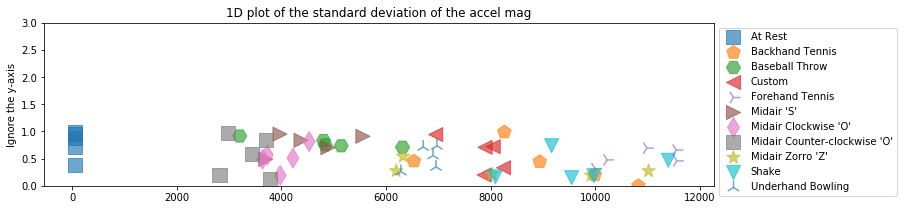

In [6]:
# Write a simple anonymous function that takes in an accel.trial and returns
# an extracted feature. In this case, the standard deviation of the magnitude
extract_feature_std_mag = lambda accel_trial: np.std(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_std_mag,
                title = "1D plot of the standard deviation of the accel mag")

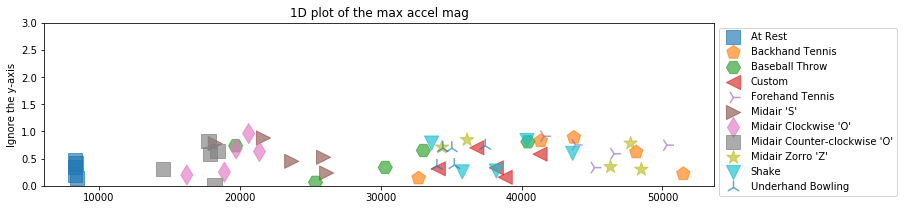

In [7]:
extract_feature_max_mag = lambda accel_trial: np.max(accel_trial.mag)
plot_feature_1d(selected_gesture_set, extract_feature_max_mag, 
                title = "1D plot of the max accel mag")

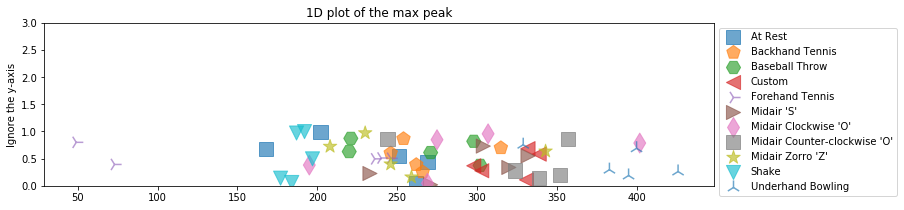

In [8]:
def extract_feature_max_peak(accel_trial):
    peaks = []
    signal = accel_trial.x_p
    for i in range(2, len(signal) - 2):
        if signal[i-2] < signal[i-1] < signal[i] > signal[i+1] > signal[i+2]:
            peaks.append(i)
    return max(peaks) if peaks else 0
    
plot_feature_1d(selected_gesture_set, extract_feature_max_peak, 
                title="1D plot of the max peak")

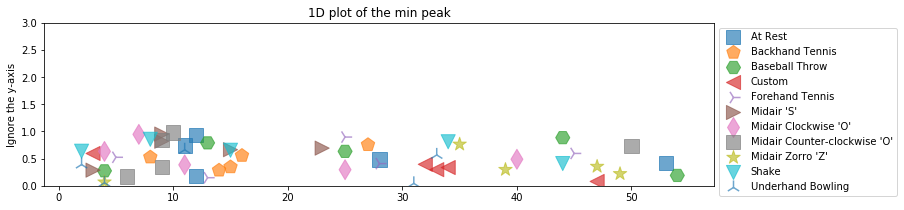

In [9]:
def extract_feature_min_peak(accel_trial):
    peaks = []
    signal = accel_trial.z_p
    for i in range(2, len(signal) - 2):
        if signal[i-2] < signal[i-1] < signal[i] > signal[i+1] > signal[i+2]:
            peaks.append(i)
    return min(peaks) if peaks else 0
    
plot_feature_1d(selected_gesture_set, extract_feature_min_peak, 
                title="1D plot of the min peak")

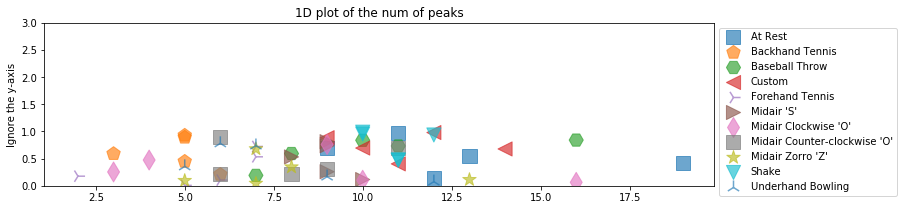

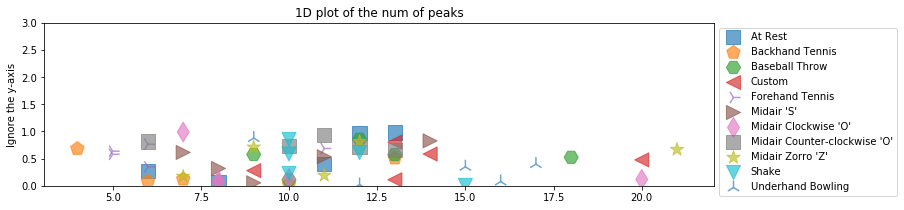

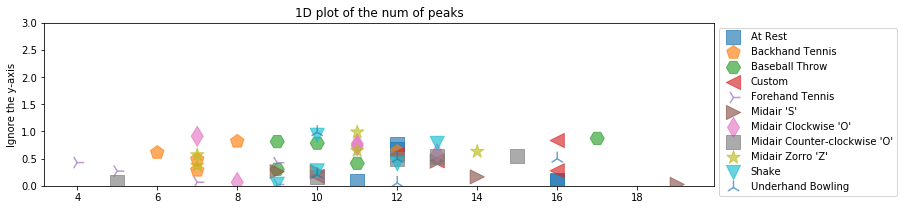

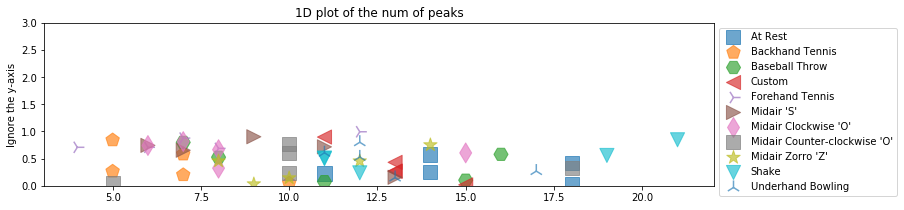

In [10]:
def extract_feature_num_peaks_x(accel_trial):
    peaks = []
    signal = accel_trial.x_p
    for i in range(2, len(signal) - 2):
        if signal[i-2] < signal[i-1] < signal[i] > signal[i+1] > signal[i+2]:
            peaks.append(i)
    return len(peaks)
    
def extract_feature_num_peaks_y(accel_trial):
    peaks = []
    signal = accel_trial.y_p
    for i in range(2, len(signal) - 2):
        if signal[i-2] < signal[i-1] < signal[i] > signal[i+1] > signal[i+2]:
            peaks.append(i)
    return len(peaks)

def extract_feature_num_peaks_z(accel_trial):
    peaks = []
    signal = accel_trial.z_p
    for i in range(2, len(signal) - 2):
        if signal[i-2] < signal[i-1] < signal[i] > signal[i+1] > signal[i+2]:
            peaks.append(i)
    return len(peaks)

def extract_feature_num_peaks_mag(accel_trial):
    peaks = []
    signal = accel_trial.mag_p
    for i in range(2, len(signal) - 2):
        if signal[i-2] < signal[i-1] < signal[i] > signal[i+1] > signal[i+2]:
            peaks.append(i)
    return len(peaks)
    
plot_feature_1d(selected_gesture_set, extract_feature_num_peaks_x, 
                title="1D plot of the num of peaks")

plot_feature_1d(selected_gesture_set, extract_feature_num_peaks_y, 
                title="1D plot of the num of peaks")

plot_feature_1d(selected_gesture_set, extract_feature_num_peaks_z, 
                title="1D plot of the num of peaks")

plot_feature_1d(selected_gesture_set, extract_feature_num_peaks_mag, 
                title="1D plot of the num of peaks")

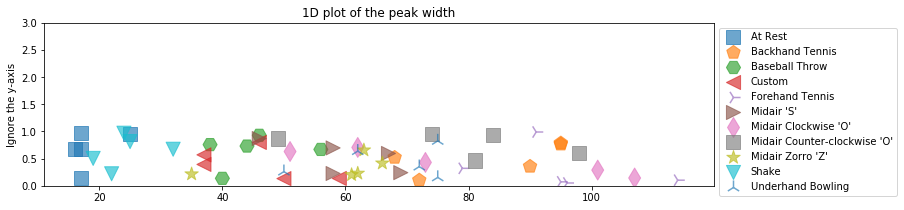

In [11]:
def extract_feature_peak_width(accel_trial):
    peak_widths = []
    signal = accel_trial.mag_p
    for i in range(2, len(signal) - 2):
        if signal[i-2] < signal[i-1] < signal[i] > signal[i+1] > signal[i+2]:
            width = 0
            idx = i
            while signal[idx - 1] < signal[idx] and idx > 1:
                width += 1
                idx -= 1
                
            idx = i
            while signal[idx + 1] < signal[idx] and idx < len(signal) - 2:
                width += 1
                idx += 1
            peak_widths.append(width)
            
    return max(peak_widths) if peak_widths else 0
    
plot_feature_1d(selected_gesture_set, extract_feature_peak_width, 
                title="1D plot of the peak width")

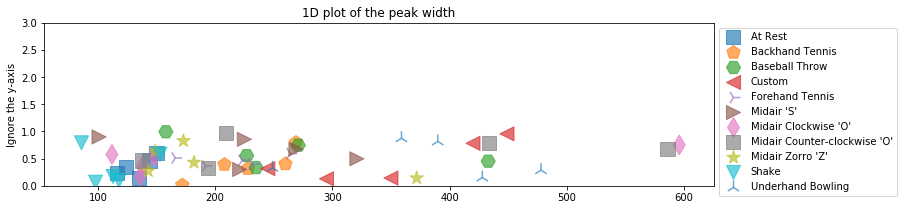

In [12]:
def extract_feature_time_moving(accel_trial):
    width = np.mean(accel_trial.z_p)
    above = accel_trial.z_p[accel_trial.z_p > width]
    below = accel_trial.z_p[accel_trial.z_p < -width]
    return len(above) + len(below)
    
plot_feature_1d(selected_gesture_set, extract_feature_time_moving, 
                title="1D plot of the peak width")

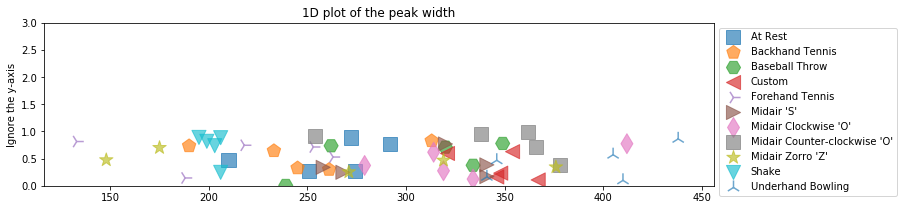

In [13]:
def extract_feature_time_moving_x(accel_trial):
    width = np.mean(accel_trial.x_p)
    above = accel_trial.z_p[accel_trial.mag_p > width]
    below = accel_trial.z_p[accel_trial.mag_p < -width]
    return len(above) + len(below)
    
plot_feature_1d(selected_gesture_set, extract_feature_time_moving_x, 
                title="1D plot of the peak width")

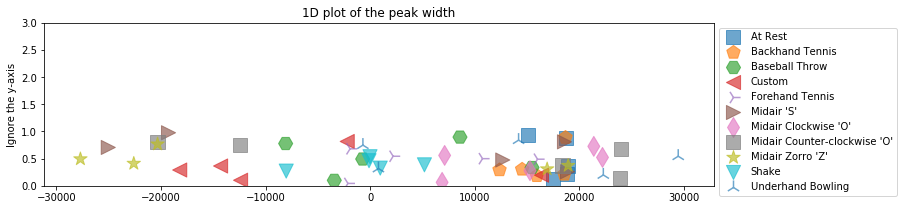

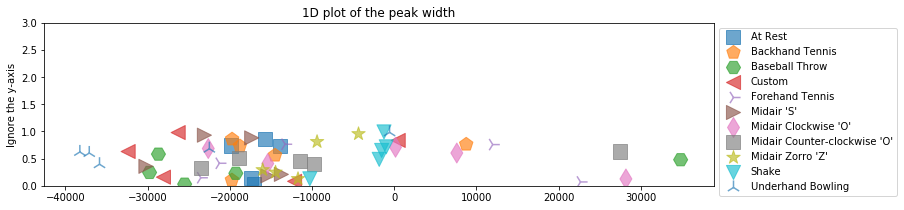

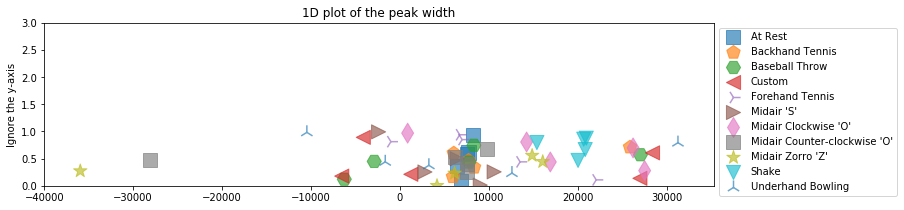

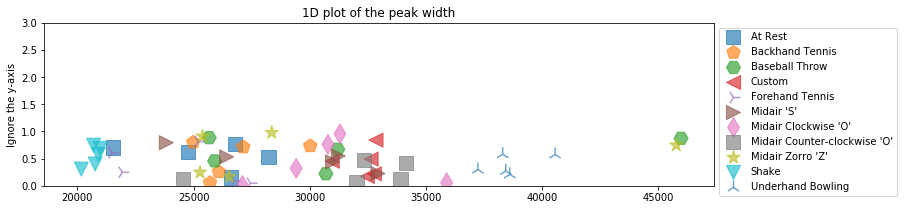

In [14]:
def extract_feature_time_moving_above_x(accel_trial):
    import math
    
    signal = accel_trial.x_p
    width = len(signal)
    ret = 0
    for i, v in enumerate(signal):
        ret += v * math.exp(-i / (width / 100))
    return ret

def extract_feature_time_moving_above_y(accel_trial):
    import math
    
    signal = accel_trial.y_p
    width = len(signal)
    ret = 0
    for i, v in enumerate(signal):
        ret += v * math.exp(-i / (width / 100))
    return ret

def extract_feature_time_moving_above_z(accel_trial):
    import math
    
    signal = accel_trial.z_p
    width = len(signal)
    ret = 0
    for i, v in enumerate(signal):
        ret += v * math.exp(-i / (width / 100))
    return ret
    
def extract_feature_time_moving_above_mag(accel_trial):
    import math
    
    signal = accel_trial.mag_p
    width = len(signal)
    ret = 0
    for i, v in enumerate(signal):
        ret += v * math.exp(-i / (width / 100))
    return ret    
    
plot_feature_1d(selected_gesture_set, extract_feature_time_moving_above_x, 
                title="1D plot of the peak width")

plot_feature_1d(selected_gesture_set, extract_feature_time_moving_above_y, 
                title="1D plot of the peak width")

plot_feature_1d(selected_gesture_set, extract_feature_time_moving_above_z, 
                title="1D plot of the peak width")

plot_feature_1d(selected_gesture_set, extract_feature_time_moving_above_mag, 
                title="1D plot of the peak width")


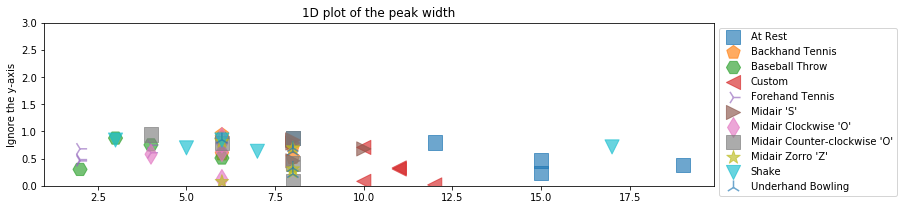

In [15]:
def extract_feature_number_zero_crossings(accel_trial):
    num_crossings = 0
    signal = accel_trial.mag_p
    mean = np.mean(accel_trial.mag_p)
    width = 5
    for i in range(width, len(signal) - width):
        crosses = True
        for j in range(1, width):
            crosses &= signal[i - j] < mean
        for j in range(1, width):
            crosses &= signal[i + j] >= mean
        if crosses:
            num_crossings += 1
    return num_crossings
    
plot_feature_1d(selected_gesture_set, extract_feature_number_zero_crossings, 
                title="1D plot of the peak width")

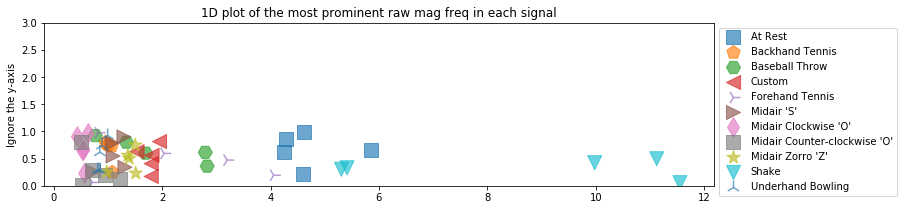

In [16]:
def extract_feature_top_mag_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq, 
                title = "1D plot of the most prominent raw mag freq in each signal")

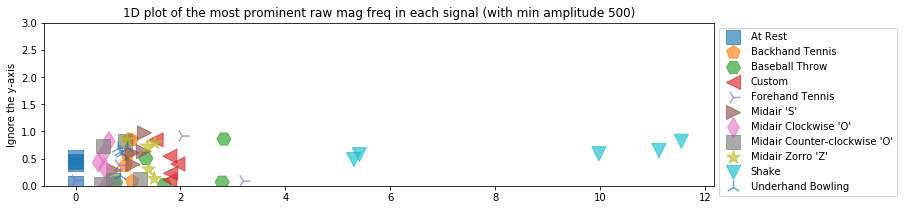

In [17]:
def extract_feature_top_mag_freq2(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 500)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = "1D plot of the most prominent raw mag freq in each signal (with min amplitude 500)")

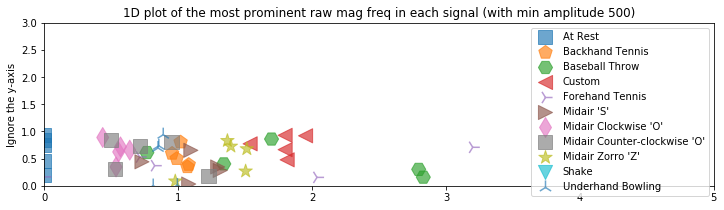

In [18]:
plot_feature_1d(selected_gesture_set, extract_feature_top_mag_freq2, 
                title = "1D plot of the most prominent raw mag freq in each signal (with min amplitude 500)",
                xlim = (0, 5))

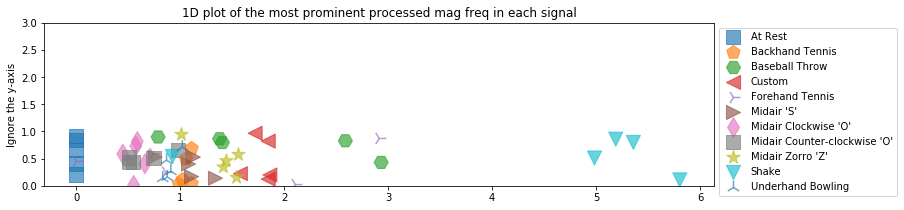

In [19]:
def extract_feature_top_mag_p_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    top_n_freq_with_amplitudes = get_top_n_frequency_peaks(1, fft_freqs, fft_amplitudes, min_amplitude_threshold = 500)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

plot_feature_1d(selected_gesture_set, extract_feature_top_mag_p_freq, 
                title = "1D plot of the most prominent processed mag freq in each signal")

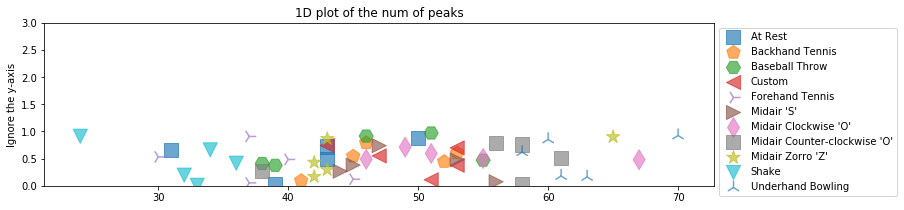

In [20]:
def extract_feature_num_peaks_freq(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    (fft_freqs, fft_amplitudes) = compute_fft(accel_trial.mag_p, sampling_rate)
    signal = fft_amplitudes
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i-1] < signal[i] > signal[i+1]:
            peaks.append(i)
    return len(peaks)
    
plot_feature_1d(selected_gesture_set, extract_feature_num_peaks_freq, 
                title="1D plot of the num of peaks")

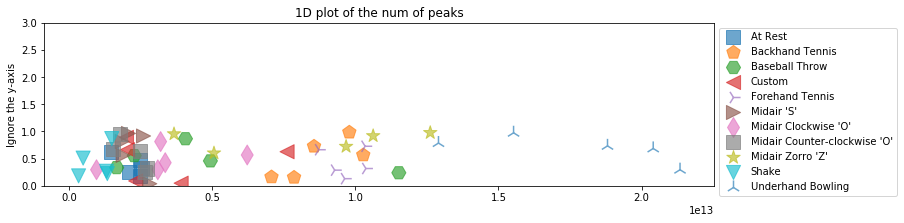

In [21]:
def extract_feature_signal_energy(accel_trial):
    sampling_rate = math.ceil(accel_trial.sampling_rate)
    fft_result = np.fft.fft(accel_trial.x_p, len(accel_trial.x_p))
    return np.sum(np.absolute(fft_result) * np.absolute(fft_result))
    
plot_feature_1d(selected_gesture_set, extract_feature_signal_energy, 
                title="1D plot of the num of peaks")

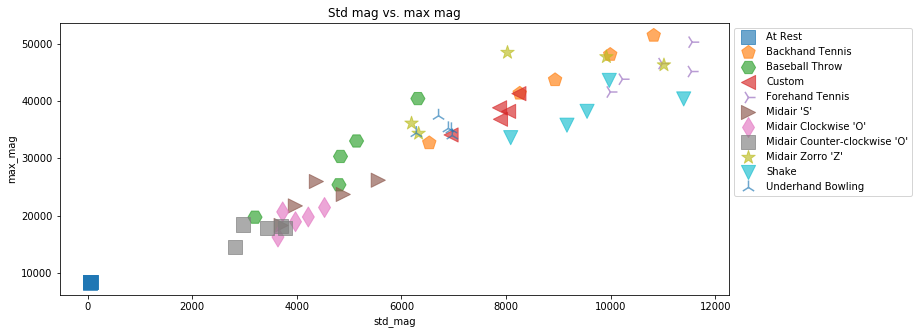

In [22]:
plot_feature_2d(selected_gesture_set, extract_feature_std_mag, extract_feature_max_mag,
               xlabel="std_mag", ylabel="max_mag", title="Std mag vs. max mag")

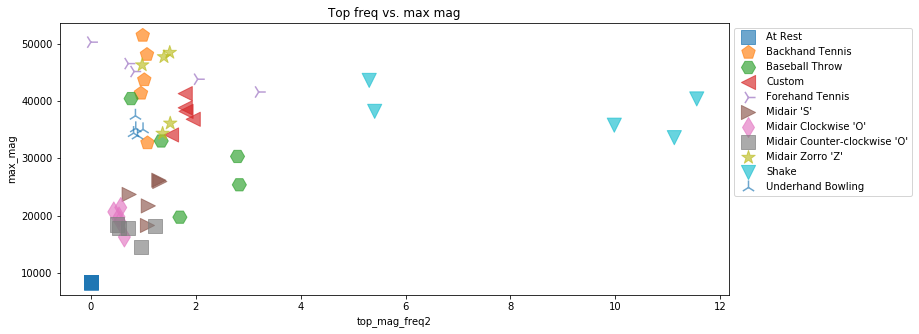

In [23]:
plot_feature_2d(selected_gesture_set, extract_feature_top_mag_freq2, extract_feature_max_mag,
               xlabel="top_mag_freq2", ylabel="max_mag", title="Top freq vs. max mag")

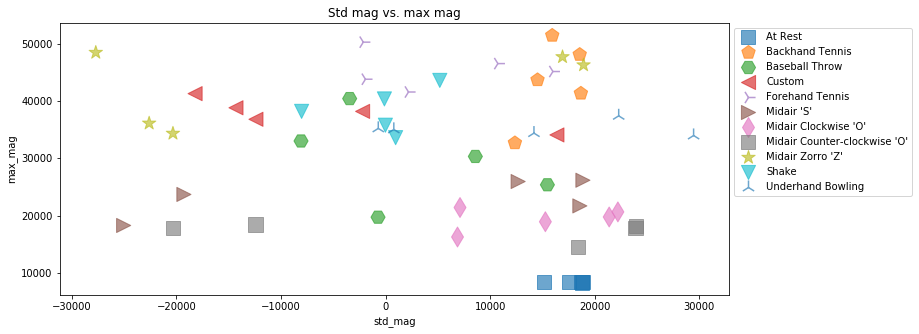

In [24]:
plot_feature_2d(selected_gesture_set, extract_feature_time_moving_above_x, extract_feature_max_mag,
               xlabel="std_mag", ylabel="max_mag", title="Std mag vs. max mag")

In [25]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is currently: {selected_gesture_set.name}")

We have 27 gesture sets:
 AGestures with 55 trials
 AlexandraGestures with 55 trials
 AlexisGestures with 55 trials
 AnjaliGestures with 55 trials
 BrettGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 DustinGestures with 55 trials
 EmmaGestures with 55 trials
 JaeHGestures with 55 trials
 JasonGestures with 55 trials
 JonGestures with 55 trials
 JuliaBGestures with 55 trials
 JustinGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 NanGestures with 55 trials
 NeilGestures with 55 trials
 NickGestures with 55 trials
 NooseGestures with 55 trials
 OjasviGestures with 55 trials
 Paf2Gestures with 55 trials
 SamuelRGestures with 55 trials
 ShaunGestures with 55 trials
 StacyGestures with 55 trials
 ThweidGestures with 55 trials
 WolfGestures with 55 trials
The selected gesture set is currently: BrettGestures


---
# Classification Experiments

In [26]:
# Grab a gesture set. I'm using "Justin" but feel free to play with any others, including your own (obviously!)
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns=feature_names)

# We don't want the trial number or gesturer to be an input feature, so remove
trial_indices = df.pop("trial_num") 
gesturer = df.pop('gesturer')
y = df.pop('gesture')

# Scikit-learn documentation consistently refer to the input feature table as X
# and the ground truth labels for this table as either y or y_true. We'll 
# use the same naming conventions
X = df

kfold_seed = 3 # setting this seed allows us to control the same random split everytime
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

Results for JonGestures
Overall AdaBoost accuracy: 89.09%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       0.83      1.00      0.91         5
              Baseball Throw       1.00      1.00      1.00         5
                      Custom       0.83      1.00      0.91         5
             Forehand Tennis       0.67      0.40      0.50         5
                  Midair 'S'       1.00      0.80      0.89         5
        Midair Clockwise 'O'       1.00      0.80      0.89         5
Midair Counter-clockwise 'O'       0.71      1.00      0.83         5
            Midair Zorro 'Z'       0.83      1.00      0.91         5
                       Shake       1.00      1.00      1.00         5
           Underhand Bowling       1.00      0.80      0.89         5

                    accuracy                           0.89        55
                   macro avg  

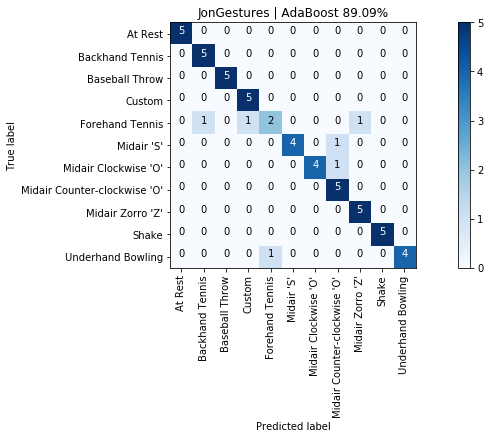

Per Gesture Accuracy (AdaBoost)
                              accuracy
At Rest                            1.0
Backhand Tennis                    1.0
Baseball Throw                     1.0
Custom                             1.0
Forehand Tennis                    0.4
Midair 'S'                         0.8
Midair Clockwise 'O'               0.8
Midair Counter-clockwise 'O'       1.0
Midair Zorro 'Z'                   1.0
Shake                              1.0
Underhand Bowling                  0.8


In [27]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier())
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall AdaBoost accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | AdaBoost {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

print('Per Gesture Accuracy (AdaBoost)')
print_per_gesture_accuracy(y, y_pred)

Results for JonGestures
Overall VotingClassifier accuracy: 94.55%
                              precision    recall  f1-score   support

                     At Rest       1.00      1.00      1.00         5
             Backhand Tennis       1.00      1.00      1.00         5
              Baseball Throw       1.00      1.00      1.00         5
                      Custom       0.83      1.00      0.91         5
             Forehand Tennis       1.00      0.40      0.57         5
                  Midair 'S'       1.00      1.00      1.00         5
        Midair Clockwise 'O'       1.00      1.00      1.00         5
Midair Counter-clockwise 'O'       1.00      1.00      1.00         5
            Midair Zorro 'Z'       0.71      1.00      0.83         5
                       Shake       1.00      1.00      1.00         5
           Underhand Bowling       1.00      1.00      1.00         5

                    accuracy                           0.95        55
                   mac

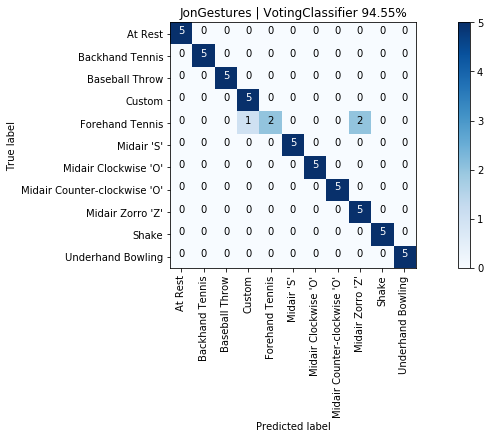

Per Gesture Accuracy (VotingClassifier)
                              accuracy
At Rest                            1.0
Backhand Tennis                    1.0
Baseball Throw                     1.0
Custom                             1.0
Forehand Tennis                    0.4
Midair 'S'                         1.0
Midair Clockwise 'O'               1.0
Midair Counter-clockwise 'O'       1.0
Midair Zorro 'Z'                   1.0
Shake                              1.0
Underhand Bowling                  1.0


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

clf = VotingClassifier(estimators=[
    ('svc_linear', SVC(kernel='linear', C=0.4)),
    ('ab', AdaBoostClassifier(base_estimator=RandomForestClassifier())),
    ('rf', RandomForestClassifier())])
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

print(f"Results for {selected_gesture_set.name}")
y_pred = cross_val_predict(pipeline, X, y, cv=skf)
print("Overall VotingClassifier accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))
print(classification_report(y, y_pred, target_names=sorted_gesture_names))

cm = confusion_matrix(y, y_pred, labels=sorted_gesture_names)
graph_title = f"{selected_gesture_set.name} | VotingClassifier {accuracy_score(y, y_pred) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)

print('Per Gesture Accuracy (VotingClassifier)')
print_per_gesture_accuracy(y, y_pred)

Results for AGestures
Accuracy: 96.36%
Results for AlexandraGestures
Accuracy: 98.18%
Results for AlexisGestures
Accuracy: 89.09%
Results for AnjaliGestures
Accuracy: 98.18%
Results for BrettGestures
Accuracy: 76.36%
Results for BryanGestures
Accuracy: 92.73%
Results for ClayGestures
Accuracy: 85.45%
Results for DustinGestures
Accuracy: 83.64%
Results for EmmaGestures
Accuracy: 98.18%
Results for JaeHGestures
Accuracy: 89.09%
Results for JasonGestures
Accuracy: 92.73%
Results for JonGestures
Accuracy: 92.73%
Results for JuliaBGestures
Accuracy: 96.36%
Results for JustinGestures
Accuracy: 92.73%
Results for MattCGestures
Accuracy: 85.45%
Results for MikaelGestures
Accuracy: 90.91%
Results for NanGestures
Accuracy: 92.73%
Results for NeilGestures
Accuracy: 90.91%
Results for NickGestures
Accuracy: 87.27%
Results for NooseGestures
Accuracy: 90.91%
Results for OjasviGestures
Accuracy: 96.36%
Results for Paf2Gestures
Accuracy: 83.64%
Results for SamuelRGestures
Accuracy: 87.27%
Results for 

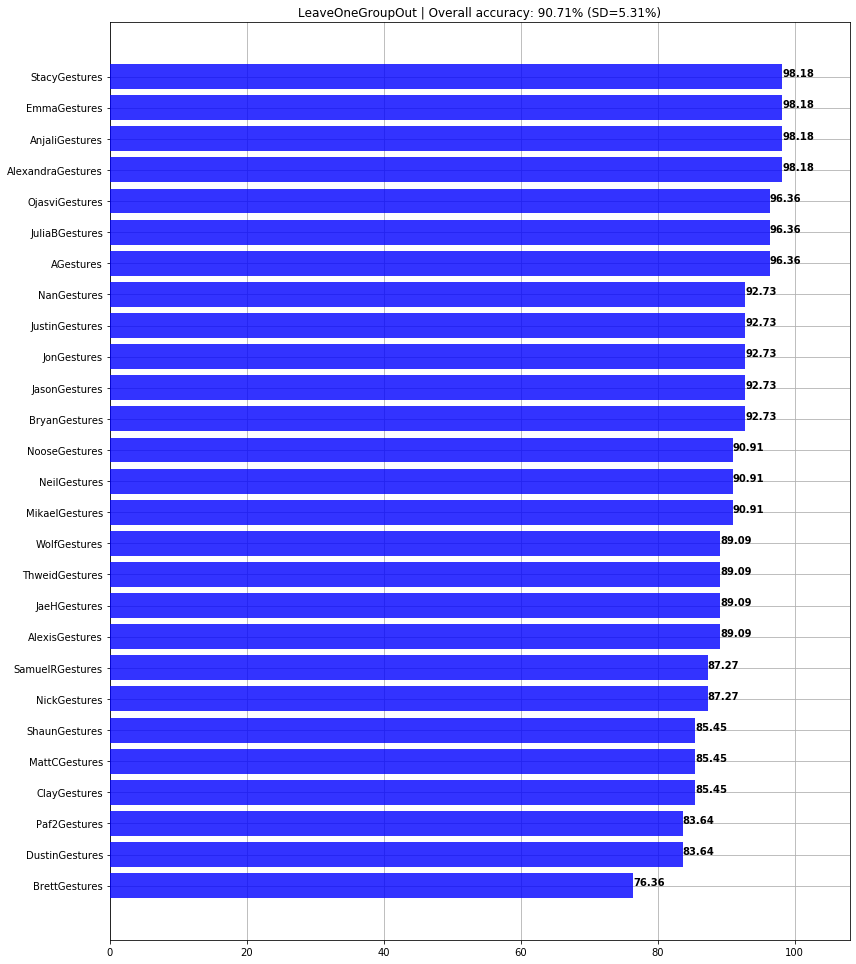

In [29]:

# Extract all features across *all* gesture sets. We'll manage which is used for training and test below
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(map_gesture_sets.values())
# Convert into a lovely Pandas DataFrame
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # we don't want trial_num as an input feature
scores = [] # store our overall accuracy scores

map_gesture_set_name_to_score = {}
for gesture_set_name, gesture_set in map_gesture_sets.items():
    selected_gesture_set = gesture_set

    (list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
    sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

    # We'll convert the feature vector and feature names lists into Pandas tables
    # which simply makes interacting with Scikit-learn easier
    df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

    # We don't want the trial number or gesturer to be an input feature, so remove
    trial_indices = df.pop("trial_num") 
    gesturer = df.pop('gesturer')
    y = df.pop('gesture')

    # Scikit-learn documentation consistently refer to the input feature table as X
    # and the ground truth labels for this table as either y or y_true. We'll 
    # use the same naming conventions
    X = df

    kfold_seed = 3 # setting this seed allows us to control the same random split everytime
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

    clf = VotingClassifier(estimators=[
        ('svc_linear', SVC(kernel='linear', C=0.4)),
        ('ab', AdaBoostClassifier(base_estimator=RandomForestClassifier())),
        ('rf', RandomForestClassifier())])
    
    scaler = StandardScaler()
    pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

    print(f"Results for {selected_gesture_set.name}")
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)
    print("Accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))

    map_gesture_set_name_to_score[gesture_set_name] = accuracy_score(y, y_pred) * 100
    scores.append(accuracy_score(y, y_pred))
    
print("--------")
print(f"Overall cross-user accuracy: {np.mean(scores)*100:0.2f}% (SD={np.std(scores)*100:0.2f}%)")
print(f"{min(scores)*100:0.2f}% {max(scores)*100:0.2f}%")

graph_title = f"LeaveOneGroupOut | Overall accuracy: {np.mean(scores)*100:0.2f}% (SD={np.std(scores)*100:0.2f}%)"
plot_bar_graph(map_gesture_set_name_to_score, title=graph_title)

In [30]:
# Extract all features across *all* gesture sets. We'll manage which is used for training and test below
(list_of_feature_vectors, feature_names) = extract_features_from_gesture_sets(map_gesture_sets.values())
# Convert into a lovely Pandas DataFrame
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # we don't want trial_num as an input feature
scores = [] # store our overall accuracy scores

def run_classifier(clf):
    map_gesture_set_name_to_score = {}
    for gesture_set_name, gesture_set in map_gesture_sets.items():
        selected_gesture_set = gesture_set

        (list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
        sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

        # We'll convert the feature vector and feature names lists into Pandas tables
        # which simply makes interacting with Scikit-learn easier
        df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

        # We don't want the trial number or gesturer to be an input feature, so remove
        trial_indices = df.pop("trial_num") 
        gesturer = df.pop('gesturer')
        y = df.pop('gesture')

        # Scikit-learn documentation consistently refer to the input feature table as X
        # and the ground truth labels for this table as either y or y_true. We'll 
        # use the same naming conventions
        X = df

        kfold_seed = 3 # setting this seed allows us to control the same random split everytime
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

        scaler = StandardScaler()
        pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

        y_pred = cross_val_predict(pipeline, X, y, cv=skf)

        map_gesture_set_name_to_score[gesture_set_name] = accuracy_score(y, y_pred) * 100
        scores.append(accuracy_score(y, y_pred))
    return map_gesture_set_name_to_score

map_clf_to_scores = {}
for name, clf in (
    ('dt', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('svc_linear', SVC(kernel='linear', C=0.4)),
    ('svc_rbf', SVC(kernel='rbf', C=0.4)),
    ('gb', GradientBoostingClassifier()),
    ('ab', AdaBoostClassifier(base_estimator=RandomForestClassifier())),
    ('rf', RandomForestClassifier())):
    
    map_clf_to_scores[name] = run_classifier(clf)

In [31]:
df_map_clf_to_scores = pd.DataFrame(map_clf_to_scores)
df_map_clf_to_scores

,dt,knn,svc_linear,svc_rbf,gb,ab,rf
AGestures,74.545455,83.636364,94.545455,90.909091,80.000000,92.727273,94.545455
AlexandraGestures,83.636364,83.636364,94.545455,90.909091,69.090909,94.545455,96.363636
AlexisGestures,78.181818,65.454545,83.636364,78.181818,63.636364,87.272727,89.090909
AnjaliGestures,83.636364,81.818182,96.363636,90.909091,87.272727,98.181818,98.181818
BrettGestures,56.363636,54.545455,65.454545,67.272727,38.181818,74.545455,70.909091
BryanGestures,74.545455,78.181818,92.727273,87.272727,80.000000,96.363636,96.363636
ClayGestures,85.454545,67.272727,90.909091,83.636364,67.272727,83.636364,87.272727
DustinGestures,63.636364,72.727273,80.000000,78.181818,54.545455,80.000000,76.363636
EmmaGestures,80.000000,80.000000,92.727273,92.727273,80.000000,96.363636,96.363636
JaeHGestures,72.727273,76.363636,81.818182,81.818182,67.272727,89.090909,87.272727


In [32]:
df_map_clf_to_scores.corr()

,dt,knn,svc_linear,svc_rbf,gb,ab,rf
dt,1.000000,0.481020,0.714624,0.642106,0.609937,0.645985,0.713998
knn,0.481020,1.000000,0.720235,0.793106,0.745532,0.716958,0.607568
svc_linear,0.714624,0.720235,1.000000,0.861029,0.809703,0.758736,0.863638
svc_rbf,0.642106,0.793106,0.861029,1.000000,0.789269,0.751450,0.764500
gb,0.609937,0.745532,0.809703,0.789269,1.000000,0.853385,0.858048
ab,0.645985,0.716958,0.758736,0.751450,0.853385,1.000000,0.895735
rf,0.713998,0.607568,0.863638,0.764500,0.858048,0.895735,1.000000


Results for AGestures
Accuracy: 89.09%
Results for AlexandraGestures
Accuracy: 92.73%
Results for AlexisGestures
Accuracy: 90.91%
Results for AnjaliGestures
Accuracy: 98.18%
Results for BrettGestures
Accuracy: 72.73%
Results for BryanGestures
Accuracy: 96.36%
Results for ClayGestures
Accuracy: 85.45%
Results for DustinGestures
Accuracy: 80.00%
Results for EmmaGestures
Accuracy: 90.91%
Results for JaeHGestures
Accuracy: 87.27%
Results for JasonGestures
Accuracy: 87.27%
Results for JonGestures
Accuracy: 90.91%
Results for JuliaBGestures
Accuracy: 92.73%
Results for JustinGestures
Accuracy: 92.73%
Results for MattCGestures
Accuracy: 81.82%
Results for MikaelGestures
Accuracy: 90.91%
Results for NanGestures
Accuracy: 94.55%
Results for NeilGestures
Accuracy: 90.91%
Results for NickGestures
Accuracy: 87.27%
Results for NooseGestures
Accuracy: 89.09%
Results for OjasviGestures
Accuracy: 96.36%
Results for Paf2Gestures
Accuracy: 80.00%
Results for SamuelRGestures
Accuracy: 89.09%
Results for 

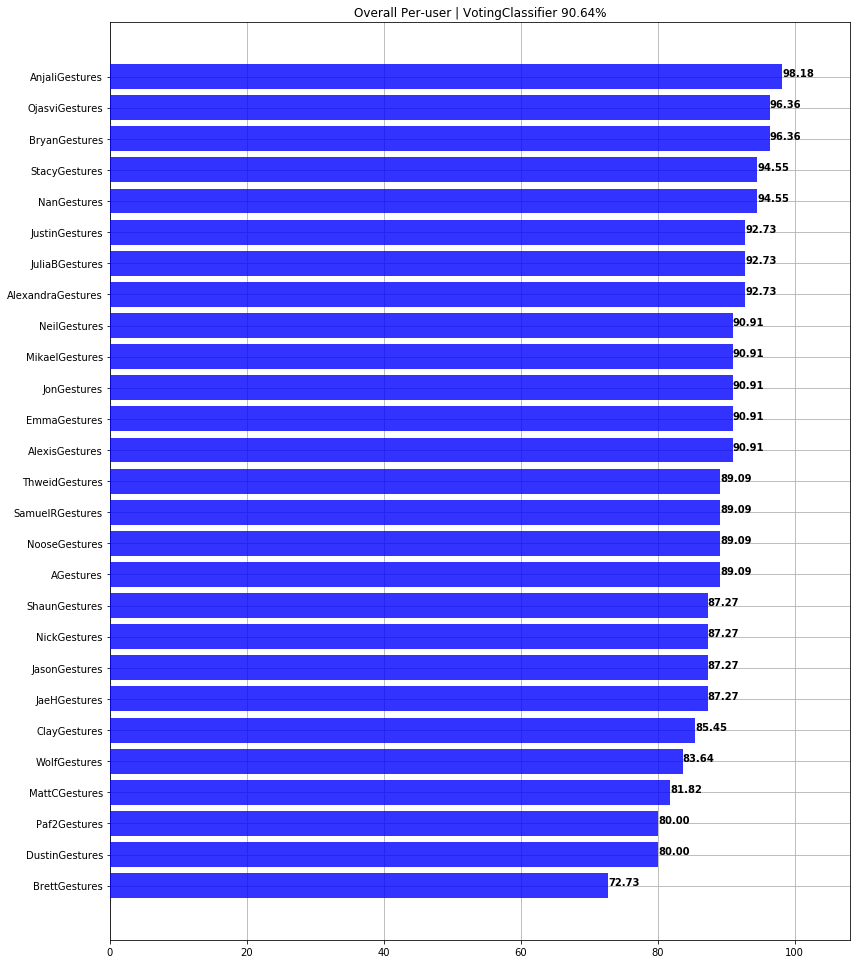

In [50]:
# Convert into a lovely Pandas DataFrame
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)
trial_indices = df.pop("trial_num") # we don't want trial_num as an input feature
scores = [] # store our overall accuracy scores

map_gesture_set_name_to_score = {}
map_gesture_set_name_to_accuracies = {}
map_gesture_set_name_to_preds = {}
for gesture_set_name, gesture_set in map_gesture_sets.items():
    selected_gesture_set = gesture_set

    (list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
    sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

    # We'll convert the feature vector and feature names lists into Pandas tables
    # which simply makes interacting with Scikit-learn easier
    df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

    # We don't want the trial number or gesturer to be an input feature, so remove
    trial_indices = df.pop("trial_num") 
    gesturer = df.pop('gesturer')
    y = df.pop('gesture')

    # Scikit-learn documentation consistently refer to the input feature table as X
    # and the ground truth labels for this table as either y or y_true. We'll 
    # use the same naming conventions
    X = df

    kfold_seed = 3 # setting this seed allows us to control the same random split everytime
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=kfold_seed)

    clf = VotingClassifier(estimators=[
        ('svc_linear', SVC(kernel='linear', C=0.4)),
        ('ab', AdaBoostClassifier(base_estimator=RandomForestClassifier())),
        ('rf', RandomForestClassifier())])
    clf = AdaBoostClassifier(base_estimator=RandomForestClassifier())
    scaler = StandardScaler()
    pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

    print(f"Results for {selected_gesture_set.name}")
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)
    print("Accuracy: {:.2f}%".format(accuracy_score(y, y_pred) * 100))

    map_gesture_set_name_to_score[gesture_set_name] = accuracy_score(y, y_pred) * 100
    map_gesture_set_name_to_accuracies[gesture_set_name] = per_gesture_accuracy(y, y_pred)
    map_gesture_set_name_to_preds[gesture_set_name] = {'labels': y, 'preds': y_pred}
    scores.append(accuracy_score(y, y_pred))
    
print("--------")
print(f"Overall cross-user accuracy: {np.mean(scores)*100:0.2f}% (SD={np.std(scores)*100:0.2f}%)")
print(f"{min(scores)*100:0.2f}% {max(scores)*100:0.2f}%")

plot_bar_graph(map_gesture_set_name_to_score, title=graph_title)

In [51]:
pd.DataFrame(map_gesture_set_name_to_accuracies).dropna().transpose() / 5.0

,At Rest,Backhand Tennis,Baseball Throw,Forehand Tennis,Midair 'S',Midair Clockwise 'O',Midair Counter-clockwise 'O',Midair Zorro 'Z',Shake,Underhand Bowling
AGestures,1.0,0.8,0.8,0.8,1.0,1.0,0.8,0.8,1.0,0.8
AlexandraGestures,1.0,0.8,1.0,1.0,0.6,0.8,1.0,1.0,1.0,1.0
AlexisGestures,1.0,1.0,1.0,0.6,0.8,1.0,0.8,1.0,1.0,0.8
AnjaliGestures,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,1.0
BrettGestures,1.0,0.6,0.4,0.8,0.2,0.6,0.6,0.8,1.0,1.0
BryanGestures,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8
ClayGestures,1.0,0.4,0.8,0.8,1.0,0.8,1.0,1.0,1.0,0.8
DustinGestures,1.0,0.6,0.4,0.6,0.8,0.8,1.0,1.0,1.0,0.8
EmmaGestures,1.0,1.0,1.0,0.8,1.0,0.6,0.8,0.8,1.0,1.0
JaeHGestures,1.0,0.6,0.8,0.6,1.0,0.8,1.0,1.0,1.0,0.8


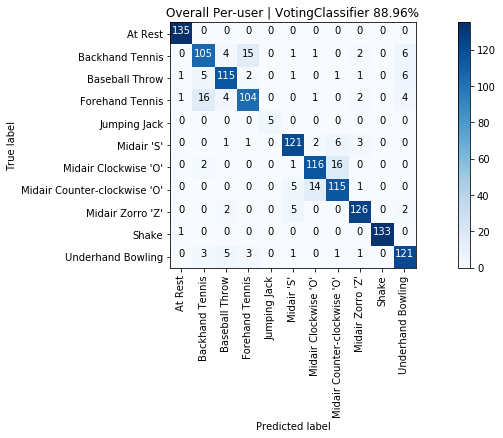

In [52]:
from collections import defaultdict
total_accuracies = defaultdict(lambda: defaultdict(lambda: 0))

labels = []
preds = []

for gesture_name in map_gesture_set_name_to_preds:
    for label in map_gesture_set_name_to_preds[gesture_name]['labels']:
        labels.append(label)
    for pred in map_gesture_set_name_to_preds[gesture_name]['preds']:
        preds.append(pred)
    
cm = confusion_matrix(labels, preds, labels=sorted_gesture_names)
graph_title = f"Overall Per-user | VotingClassifier {accuracy_score(labels, preds) * 100:.2f}%"
grvis.plot_confusion_matrix(cm, classes=sorted_gesture_names, title=graph_title)